# Time and Pitch Modification with STFT's ("phase vocoder")
In this part of the assignment we will modify time and pitch independently using the stft, which is historically often refered to as a "phase vocoder" in audio processing.

In [1]:
from a3py import *
import scipy as sp

def newfig(title=None):
    fig = plt.figure(figsize=(12,3));
    return fig

### Let's grab some audio...


Input Audio File ./noisyhellocs6682.wav:


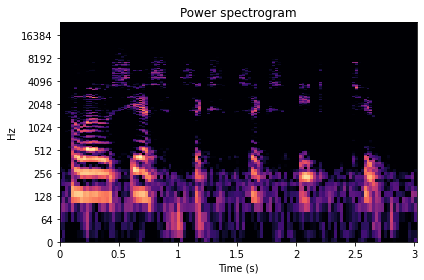

In [2]:
audio_file_path = './noisyhellocs6682.wav';
a = Audio(audio_file_path);

# Let's actually use half the audio here...
a = a.GetClip(1, 4);

print("Input Audio File {}:".format(audio_file_path));
a.play()
a.showSpectrogram();

## Using your `Signal` implementation to resample:
Copy your `Signal` implementation from [./ResamplingInTheFrequencyDomain.ipynb](./ResamplingInTheFrequencyDomain.ipynb) to the file [../a3py/MySignal.py](../a3py/MySignal.py). Once you do this, the function `Audio.GetResampledToLength(new_length)` should work using the resampling code you wrote in your `Signal` class.

-36000.0
36000.0
108000.0
144000


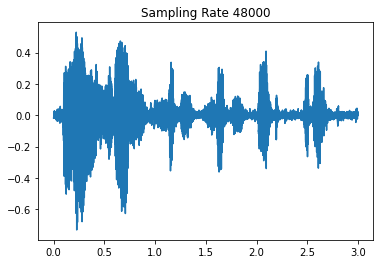

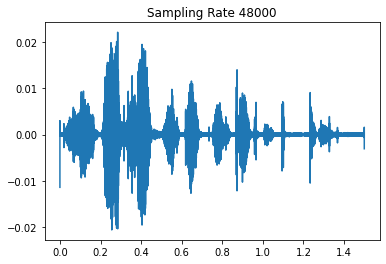

In [3]:
ar = a.GetResampledToLength(int(len(a.samples)*0.5));
ar.play()

a.plot()
plt.title("Sampling Rate {}".format(a.sampling_rate));
plt.show()
ar.plot()
plt.title("Sampling Rate {}".format(ar.sampling_rate));

### Now, if we just interpret the downsampled signal as having the same sampling rate as the original, listen to what happens:

In [4]:
ar.sampling_rate = a.sampling_rate;
ar.play()

### Let's turn this into a function...

In [5]:
def NaiveSpeedChange(audio, duration_multiplier):
    old_len=int(len(audio.samples));
    new_len = int(len(audio.samples)*duration_multiplier);
    # let's make sure we aren't messing with even/oddness
    if((new_len%2)!=(old_len%2)):
        new_len=new_len+1;
    acopy = audio.GetResampledToLength(new_len);
    acopy.sampling_rate = audio.sampling_rate;
    return acopy;

In [6]:
slow=NaiveSpeedChange(a, 1.5);
fast = NaiveSpeedChange(a, 0.75);

slow.play();
fast.play()

36000.0
-36000.0
180000.0
144000
-18000.0
18000.0
126000.0
144000


We see that both duration and pitch are changed with this approach. Now let's try to change one without changing the other...

# Time Scale Modification

Now lets use the STFT to modify time and pitch independently. We will do this by:
- Using the STFT to analyze a signal according to one hop size, or *frame rate* (frame rate refers to the sampling rate of columns in the STFT)
- Using the ISTFT to synthesize a new signal based on a **different** hop size, which will result in making the signal longer or shorter without changing which frequencies we hear.

The code below shows how to take the STFT and ISTFT with specified hop and window sizes using the helper code I have provided.

Original:


STFT->ISTFT


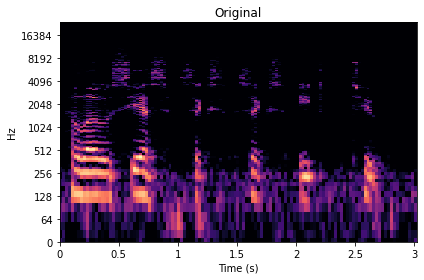

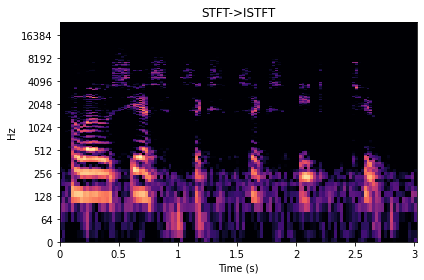

In [7]:
window_size = 2048;
hop_size = 64;

stft = STFT.FromAudio(a, window_size=window_size, hop_size=hop_size);
istft = stft.GetISTFTAudio(window_size=window_size, hop_size=hop_size);


print("Original:")
a.play();
a.showSpectrogram("Original")

print('STFT->ISTFT');
istft.play()
istft.showSpectrogram('STFT->ISTFT');


## Complete this function that changes the speed of the audio.
My implementation is only a couple of lines. Don't over think it. Don't worry about phase correction.

In [22]:
def GetAudioWithSpeedChanged(input_audio, duration_multiplier, hop_size=512, window_size=2048):
#     raise NotImplementedError;
    adj_window_size = duration_multiplier*window_size;
    adj_hop_size = duration_multiplier*hop_size;
    
    stft = STFT.FromAudio(input_audio, window_size= window_size, hop_size= hop_size);
    istft = stft.GetISTFTAudio(window_size= adj_window_size, hop_size= adj_hop_size);
    return istft;

In [30]:
#Note: There is a strange bug with window size when the multiplier goes beyond normal, 
#i havent been able to figure out why, so i reduced the loop ranges for now
for i in range(5):
    dmult = 0.5+0.1*i
    print("Duration Multiplier: {}".format(dmult));
    print('Naive speed change:');
    NaiveSpeedChange(a, dmult).play();
    print("Phase Vocoder Without Phase Correction:");
    GetAudioWithSpeedChanged(a, dmult).play()

Duration Multiplier: 0.5
Naive speed change:
-36000.0
36000.0
108000.0
144000


Phase Vocoder Without Phase Correction:


Duration Multiplier: 0.6
Naive speed change:
-28800.0
28800.0
115200.0
144000


Phase Vocoder Without Phase Correction:


Duration Multiplier: 0.7
Naive speed change:
-21600.0
21600.0
122400.0
144000


Phase Vocoder Without Phase Correction:


Duration Multiplier: 0.8
Naive speed change:
-14400.0
14400.0
129600.0
144000


Phase Vocoder Without Phase Correction:


Duration Multiplier: 0.9
Naive speed change:
-7200.0
7200.0
136800.0
144000


Phase Vocoder Without Phase Correction:


### Some Notes:
- It's worth pointing out that if you tune the window and hop sizes you can do a bit better with time scale modification that ignores phase.
- If you fix up phase, you can do much better. There are sophisticated ways to do this, and I recommend [rubberband](https://breakfastquay.com/rubberband/) to anyone curious.
- Below we will compare against librosa's phase vocoder with phase correction.

In [31]:
for i in range(4):
    dmult = 0.7+0.1*i
    print("{}x Duration Without Phase Correction:".format(dmult));
    GetAudioWithSpeedChanged(a, dmult).play()
    print("{}x Duration With Phase Correction:".format(dmult));
    a.PhaseVocode(dmult).play();
    

0.7x Duration Without Phase Correction:


0.7x Duration With Phase Correction:


0.7999999999999999x Duration Without Phase Correction:


0.7999999999999999x Duration With Phase Correction:


0.8999999999999999x Duration Without Phase Correction:


0.8999999999999999x Duration With Phase Correction:


1.0x Duration Without Phase Correction:


1.0x Duration With Phase Correction:


## Pitch Shifting!
Pitch shifting is closely related to time scale manipulation. We saw how the function `NaiveSpeedChange` changes both time and pitch, while the function `GetAudioWithSpeedChanged` changes duration without changing pitch (or at least it tries to...). Combine these to change pitch without changing duration in the function `PitchShiftNoPhaseCorrection`.

Also write a version of the function, `PitchShiftWithPhaseCorrection` that uses `Audio.PhaseVocode(durationi_multiplier)` (based on `librosa`'s phase vocoder) to perform duration changes.

In [ ]:
def PitchShiftNoPhaseCorrection(audio, frequency_multiplier):
    raise NotImplementedError;
    
def PitchShiftWithPhaseCorrection(audio, frequency_multiplier):
    raise NotImplementedError;

In [ ]:
for i in range(12):
    fmult = 0.8+0.1*i
    print("Frequency Multiplier: {}".format(fmult));
    print('Without Phase Correction:');
    PitchShiftNoPhaseCorrection(a, fmult).play();
    print("Phase Vocoder With Phase Correction:");
    PitchShiftWithPhaseCorrection(a, fmult).play();

### Bonus: Fun with Harmony!

In [ ]:
pitches = [];
pitches.append(a.clone());
pitches.append(PitchShiftWithPhaseCorrection(a, 2));
pitches.append(PitchShiftWithPhaseCorrection(a, 0.5));

nsamples = np.min([pitches[0].n_samples, pitches[1].n_samples, pitches[2].n_samples]);
for p in pitches:
    p._samples = p._samples[:nsamples];

harmony = pitches[0]+pitches[1]+pitches[2];
harmony.play();


# What to hand in:
Once you have completed this notebook, run the whole thing with your own audio file used below, download the result as HTML, and hand that in to CMS.

In [ ]:
audio_file_path = PATH_TO_YOUR_AUDIO
a = Audio(audio_file_path);
print("Input Audio File {}:".format(audio_file_path));
a.play()
a.showSpectrogram();

## Time Scale:

In [ ]:
for i in range(7):
    dmult = 0.7+0.1*i
    print("{}x Duration Naive:".format(dmult));
    NaiveSpeedChange(a, dmult).play();
    print("{}x Duration Without Phase Correction:".format(dmult));
    GetAudioWithSpeedChanged(a, dmult).play()
    
    

In [ ]:
for i in range(12):
    fmult = 0.8+0.1*i
    print("Frequency Multiplier: {}".format(fmult));
    print('Without Phase Correction:');
    PitchShiftNoPhaseCorrection(a, fmult).play();
    print("Phase Vocoder With Phase Correction:");
    PitchShiftWithPhaseCorrection(a, fmult).play();